In [26]:
import shutil
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from scipy.io import wavfile
from tqdm import tqdm

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from keras.models import Sequential
from keras.utils import to_categorical, normalize
from keras.layers import Conv1D, Dense, LSTM, Flatten, Dropout, MaxPooling1D

### Looking into Patients and their Diagnosis

In [27]:
diagnosis_df = pd.read_csv('/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv', 
                           names=['Patient number', 'Diagnosis'])

In [28]:
diagnosis_df.head()

,Patient number,Diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


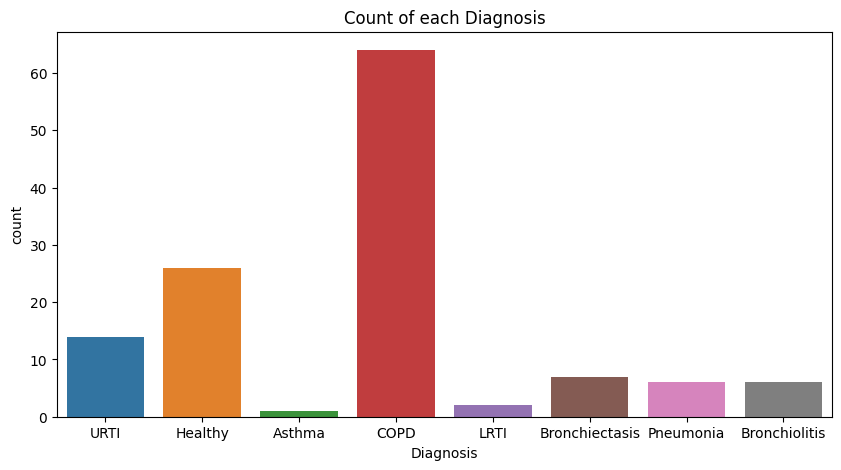

In [29]:
plt.figure(figsize=(10,5))
sns.countplot(diagnosis_df, x='Diagnosis')
plt.title('Count of each Diagnosis')
plt.show()

### Looking into Patient's Metadata

In [30]:
patient_df = pd.read_csv('/kaggle/input/respiratory-sound-database/demographic_info.txt', 
                         names=['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'],
                         delimiter = ' ')

In [31]:
patient_df.head()

,Patient number,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm)
0,101,3.00,F,NaN,19.0,99.0
1,102,0.75,F,NaN,9.8,73.0
2,103,70.00,F,33.00,NaN,NaN
3,104,70.00,F,28.47,NaN,NaN
4,105,7.00,F,NaN,32.0,135.0


In [32]:
patient_df['Adult BMI (kg/m2)'].isna().sum()

51

In [33]:
for i in range(len(patient_df)):
    if (pd.isna(patient_df['Adult BMI (kg/m2)'][i])) and (not pd.isna(patient_df['Child Weight (kg)'][i])) and (not pd.isna(patient_df['Child Height (cm)'][i])):
        patient_df['Adult BMI (kg/m2)'][i] = round(patient_df['Child Weight (kg)'][i]/np.square(0.01*patient_df['Child Height (cm)'][i]),2)

In [34]:
patient_df['Adult BMI (kg/m2)'].isna().sum()

9

In [35]:
df = pd.merge(left=patient_df, right=diagnosis_df, how='left')
df.head()

,Patient number,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm),Diagnosis
0,101,3.00,F,19.39,19.0,99.0,URTI
1,102,0.75,F,18.39,9.8,73.0,Healthy
2,103,70.00,F,33.00,NaN,NaN,Asthma
3,104,70.00,F,28.47,NaN,NaN,COPD
4,105,7.00,F,17.56,32.0,135.0,URTI


In [36]:
Patient_numbers, Recording_indices, Chest_locations, Acquisition_modes, Recording_equipments = [], [], [], [], []
folder_path = '/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files'
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        parts = filename.split('_')
        Patient_number = parts[0]
        Recording_index = parts[1]
        Chest_location = parts[2]
        Acquisition_mode = parts[3]
        Recording_equipment = parts[4].split('.')[0]
        
        Patient_numbers.append(int(Patient_number))
        Recording_indices.append(Recording_index)
        Chest_locations.append(Chest_location)
        Acquisition_modes.append(Acquisition_mode)
        Recording_equipments.append(Recording_equipment)

df1 = pd.DataFrame({'Patient number': Patient_numbers, 'Recording index': Recording_indices, 'Chest location': Chest_locations,
                    'Acquisition mode': Acquisition_modes, 'Recording equipment': Recording_equipments})

In [37]:
df1.tail()

,Patient number,Recording index,Chest location,Acquisition mode,Recording equipment
915,200,2p4,Pr,mc,AKGC417L
916,156,8b3,Ll,mc,AKGC417L
917,162,2b3,Ar,mc,AKGC417L
918,162,2b4,Pr,mc,AKGC417L
919,200,2p3,Ar,mc,AKGC417L


### Merging all the data

In [38]:
df_all = pd.merge(left=df1, right=df, how='left').sort_values('Patient number').reset_index(drop=True)
df_all.head()

,Patient number,Recording index,Chest location,Acquisition mode,Recording equipment,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm),Diagnosis
0,101,1b1,Al,sc,Meditron,3.00,F,19.39,19.0,99.0,URTI
1,101,1b1,Pr,sc,Meditron,3.00,F,19.39,19.0,99.0,URTI
2,102,1b1,Ar,sc,Meditron,0.75,F,18.39,9.8,73.0,Healthy
3,103,2b2,Ar,mc,LittC2SE,70.00,F,33.00,NaN,NaN,Asthma
4,104,1b1,Al,sc,Litt3200,70.00,F,28.47,NaN,NaN,COPD


In [39]:
df_all['audio_file_name'] = df_all.apply(lambda row: str(row['Patient number']) +'_'+ str(row['Recording index']) +'_'+ str(row['Chest location']) 
                             +'_'+ str(row['Acquisition mode']) +'_'+ str(row['Recording equipment']) + '.wav', axis=1)

In [40]:
df_main = df_all[['Patient number','audio_file_name', 'Diagnosis']]
df_main.head(20)

,Patient number,audio_file_name,Diagnosis
0,101,101_1b1_Al_sc_Meditron.wav,URTI
1,101,101_1b1_Pr_sc_Meditron.wav,URTI
2,102,102_1b1_Ar_sc_Meditron.wav,Healthy
3,103,103_2b2_Ar_mc_LittC2SE.wav,Asthma
4,104,104_1b1_Al_sc_Litt3200.wav,COPD
5,104,104_1b1_Ll_sc_Litt3200.wav,COPD
6,104,104_1b1_Ar_sc_Litt3200.wav,COPD
7,104,104_1b1_Lr_sc_Litt3200.wav,COPD
8,104,104_1b1_Pl_sc_Litt3200.wav,COPD
9,104,104_1b1_Pr_sc_Litt3200.wav,COPD


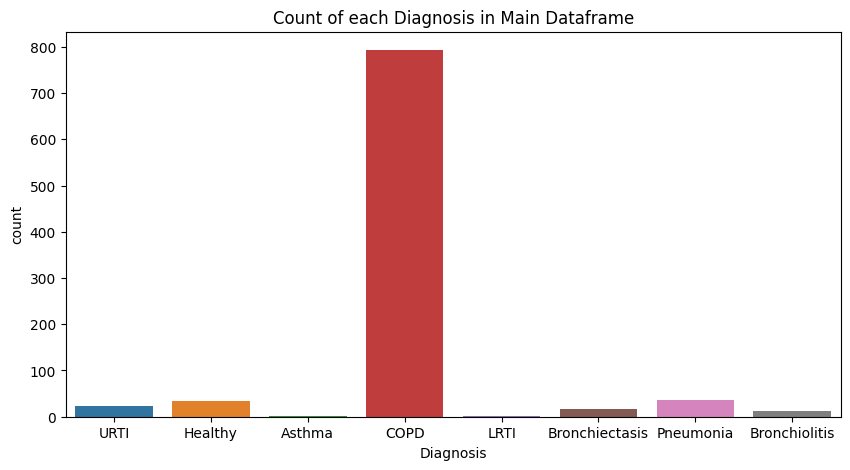

In [41]:
plt.figure(figsize=(10,5))
sns.countplot(df_main, x='Diagnosis')
plt.title('Count of each Diagnosis in Main Dataframe')
plt.show()

### Removing 'Asthma' and 'LRTI' records entirely from dataframe as they are very low in number. 'COPD' is heavily sampled. We'll deal with undersampling and oversampling the rest down the line.

In [42]:
df_main = df_main[(df_main['Diagnosis'] != 'Asthma') & (df_main['Diagnosis'] != 'LRTI')]
df_main = df_main.sort_values('Patient number').reset_index(drop=True)

In [43]:
df_main['Diagnosis'].value_counts()

Diagnosis
COPD              793
Pneumonia          37
Healthy            35
URTI               23
Bronchiectasis     16
Bronchiolitis      13
Name: count, dtype: int64

In [44]:
df_main['Diagnosis'].value_counts(normalize=True)*100

Diagnosis
COPD              86.477644
Pneumonia          4.034896
Healthy            3.816794
URTI               2.508179
Bronchiectasis     1.744820
Bronchiolitis      1.417666
Name: proportion, dtype: float64

In [45]:
df_main.head(10)

,Patient number,audio_file_name,Diagnosis
0,101,101_1b1_Al_sc_Meditron.wav,URTI
1,101,101_1b1_Pr_sc_Meditron.wav,URTI
2,102,102_1b1_Ar_sc_Meditron.wav,Healthy
3,104,104_1b1_Pl_sc_Litt3200.wav,COPD
4,104,104_1b1_Lr_sc_Litt3200.wav,COPD
5,104,104_1b1_Pr_sc_Litt3200.wav,COPD
6,104,104_1b1_Ll_sc_Litt3200.wav,COPD
7,104,104_1b1_Al_sc_Litt3200.wav,COPD
8,104,104_1b1_Ar_sc_Litt3200.wav,COPD
9,105,105_1b1_Tc_sc_Meditron.wav,URTI


### Looking into Audio Files

In [46]:
audio_files_path = '/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
audio_files = glob(os.path.join(audio_files_path, '**/*.wav'), recursive=True)

In [47]:
len(audio_files)

920

In [ ]:
# Example Audio File
ipd.Audio(audio_files[0])

In [49]:
y, sr = librosa.load(audio_files[0])
print(len(y))
print(sr)

441000
22050


In [50]:
classes = list(df_main['Diagnosis'].unique())
print(classes)

['URTI', 'Healthy', 'COPD', 'Bronchiectasis', 'Pneumonia', 'Bronchiolitis']


### Preprocessing the Audio Files

In [51]:
# Envelope refers to a curve that represents the variation over time of a certain characteristic of the audio signal.
# The envelope is often used to capture the general shape or magnitude of the signal, helping to highlight its dynamic changes.
def envelope(y, sr, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_rolling = y.rolling(window=int(sr/10), min_periods=1, center=True).mean()
    for i in y_rolling:
        if i > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [52]:
# Creating a folder in output to add cleaned audio files.
folder_path = '/kaggle/working/' + 'wavfiles_cleaned'
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)

os.makedirs(folder_path, exist_ok=True)

In [53]:
for i in tqdm(df_main['audio_file_name']):
    y, sr = librosa.load(audio_files_path + str(i), sr=22050)
    mask = envelope(y, sr, 0.0005)
    wavfile.write(filename='/kaggle/working/wavfiles_cleaned/' + str(i), rate=sr, data=y[mask])

100%|██████████| 917/917 [02:52<00:00,  5.31it/s]


### Defining a parser to extract features and labels to feed DL Models

In [54]:
def parser(row):
    audio_file_name = os.path.join('/kaggle/working/wavfiles_cleaned', str(row['audio_file_name']))
    y, sr = librosa.load(audio_file_name, sr=22050)
    
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=24).T, axis=0)
    chromagrams = np.mean(librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=24).T, axis=0)
    mel_specs = np.mean(librosa.feature.melspectrogram(y=y, sr=sr,).T, axis=0)
    spec_contrasts = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr, n_bands=6).T, axis=0)
    tonal_centroids = np.mean(librosa.feature.tonnetz(y=y, sr=sr).T, axis=0)
    
    features = np.concatenate([mfccs, chromagrams, mel_specs, spec_contrasts, tonal_centroids], axis=0)
    labels = row['Diagnosis']
    
    return [features, labels]

In [55]:
data = df_main.apply(parser, axis=1).tolist()

In [56]:
data[0]

[array([-5.28425232e+02,  1.04517365e+02,  6.99075851e+01,  4.25721245e+01,
         3.12133808e+01,  2.74905739e+01,  2.22070045e+01,  1.65510998e+01,
         1.52766991e+01,  1.66802998e+01,  1.46422129e+01,  8.42692280e+00,
         3.85719275e+00,  4.90536928e+00,  8.39979267e+00,  9.31068325e+00,
         6.85324955e+00,  3.96354818e+00,  2.85693669e+00,  3.38714695e+00,
         4.46284723e+00,  5.35197639e+00,  5.60875750e+00,  4.76154613e+00,
         7.04114377e-01,  7.25346029e-01,  7.53667116e-01,  7.85776258e-01,
         8.21523905e-01,  8.57331336e-01,  8.85435402e-01,  9.12920773e-01,
         9.36038494e-01,  9.47170556e-01,  9.36003447e-01,  9.06397760e-01,
         8.76736343e-01,  8.52024317e-01,  8.22968423e-01,  7.92576432e-01,
         7.69667625e-01,  7.48739421e-01,  7.18671262e-01,  6.88562870e-01,
         6.66394711e-01,  6.43055558e-01,  6.43532872e-01,  6.76925778e-01,
         4.62663383e+01,  1.86256199e+01,  6.16175699e+00,  2.87840915e+00,
         1.0

In [57]:
X = np.array(list(zip(*data))[0])
y = np.array(list(zip(*data))[1])

In [58]:
df_main['Diagnosis'].value_counts()

Diagnosis
COPD              793
Pneumonia          37
Healthy            35
URTI               23
Bronchiectasis     16
Bronchiolitis      13
Name: count, dtype: int64

### Resampling. We have downsized 'COPD' records by eliminating half of them randomly and oversampled the minority classes using SMOTE.

In [59]:
# Defining the desired number of samples per minority class (as a dictionary) for over-sampling
sampling_strategy_over = {'Pneumonia': 150, 'Healthy': 150, 'URTI': 100, 'Bronchiectasis': 100, 'Bronchiolitis': 100}

# Creating the SMOTE object for over-sampling minority classes
smote = SMOTE(sampling_strategy=sampling_strategy_over, k_neighbors=5, random_state=42)

# Applying SMOTE to oversample minority classes
X_resampled_over, y_resampled_over = smote.fit_resample(X, y)

# Removing half of the "COPD" samples
copd_indices = np.where(y_resampled_over == 'COPD')[0]
np.random.seed(42)
np.random.shuffle(copd_indices)
remove_indices = copd_indices[:len(copd_indices) // 2]

X_resampled = np.delete(X_resampled_over, remove_indices, axis=0)
y_resampled = np.delete(y_resampled_over, remove_indices)

In [60]:
# Final count of all classes
np.unique(y_resampled, return_counts=True)

(array(['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia',
        'URTI'], dtype='<U14'),
 array([100, 100, 397, 150, 150, 100]))

In [61]:
print('Shape of X is',X_resampled.shape)
print('Shape of y is',y_resampled.shape)

Shape of X is (997, 189)
Shape of y is (997,)


In [62]:
# Encoding the target variables
le = LabelEncoder()
y_encoded = le.fit_transform(y_resampled)
y_resampled = to_categorical(y_encoded)

In [64]:
y_resampled[0]

array([0., 0., 0., 0., 0., 1.])

In [65]:
# Splitting the data into Train and Test in 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [66]:
# Reshape training data
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], 189, 1))

# Reshape testing data
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 189, 1))

---

### 1. Simple 1D CNN Model

In [102]:
# Defining the input shape
input_shape = (189, 1)

# Defining the model
model = Sequential()

# 1st Convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))

# Dropout layer
model.add(Dropout(0.5))

# Flatten layer
model.add(Flatten())

# Dense layer
model.add(Dense(6, activation='softmax'))

In [96]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 187, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 187, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 11968)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │        71,814 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,070 (281.52 KB)

 Trainable params: 72,070 (281.52 KB)

 Non-trainable params: 0 (0.00 B)

In [103]:
# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [104]:
model.fit(X_train_reshaped, y_train, batch_size=32, epochs=125, validation_split=0.25, verbose=0)

In [105]:
# Performance on Test set
model.evaluate(X_test_reshaped, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9199 - loss: 0.2250 


[0.20805878937244415, 0.925000011920929]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


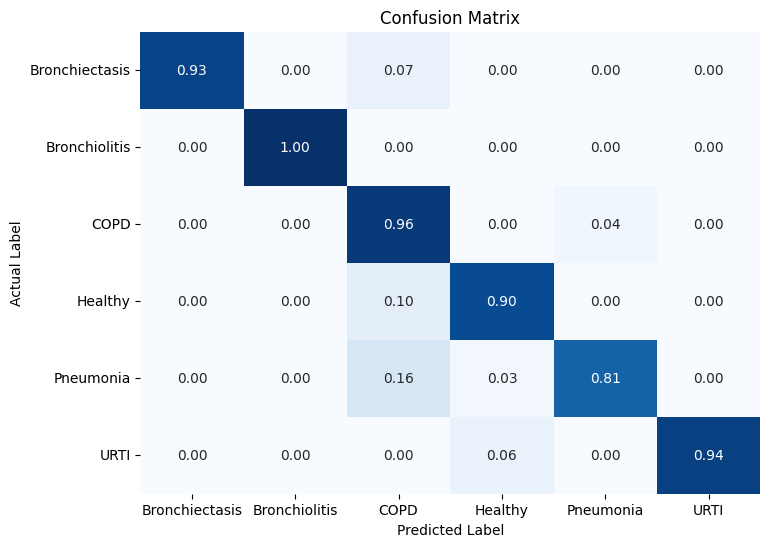

In [106]:
# Confusion Matrix
predictions = model.predict(X_test_reshaped)

predicted_classes = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), predicted_classes)
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [107]:
# Classification Report
print(classification_report(np.argmax(y_test, axis=1), predicted_classes))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        27
           1       1.00      1.00      1.00        18
           2       0.88      0.96      0.92        79
           3       0.93      0.90      0.91        29
           4       0.89      0.81      0.85        31
           5       1.00      0.94      0.97        16

    accuracy                           0.93       200
   macro avg       0.95      0.92      0.94       200
weighted avg       0.93      0.93      0.92       200



---

### 2. LSTM Model

In [74]:
# Defining the input shape
input_shape = (189, 1)

# Creating the Sequential model
model = Sequential()

# Adding LSTM layers with dropout
model.add(LSTM(units=1024, return_sequences=True, input_shape=input_shape))
model.add(Dropout(0.5))
model.add(LSTM(units=512, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=256, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.5))

# Adding MaxPooling1D layer
model.add(MaxPooling1D(pool_size=2))

# Flatten layer
model.add(Flatten())

# Dense layers
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=6, activation='softmax'))

In [75]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 189, 1024)      │     4,202,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 189, 1024)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 189, 512)       │     3,147,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 189, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 189, 256)       │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 189, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 189, 128)       │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 189, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 189, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 189, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 189, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 189, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 94, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3008)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │       300,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,698,178 (33.18 MB)

 Trainable params: 8,698,178 (33.18 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [77]:
model.fit(X_train_reshaped, y_train, batch_size=32, epochs=85, validation_split=0.25, verbose=0)

In [78]:
# Performance on Test set
model.evaluate(X_test_reshaped, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7275 - loss: 0.9155


[0.7284221053123474, 0.7400000095367432]

7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step


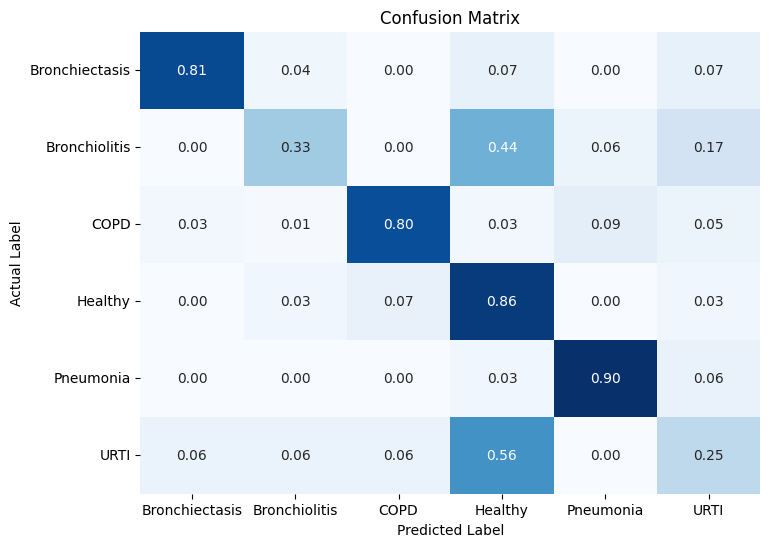

In [79]:
# Confusion Matrix
predictions = model.predict(X_test_reshaped)

predicted_classes = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), predicted_classes)
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [80]:
# Classification Report
print(classification_report(np.argmax(y_test, axis=1), predicted_classes))

              precision    recall  f1-score   support

           0       0.88      0.81      0.85        27
           1       0.60      0.33      0.43        18
           2       0.95      0.80      0.87        79
           3       0.53      0.86      0.66        29
           4       0.78      0.90      0.84        31
           5       0.25      0.25      0.25        16

    accuracy                           0.74       200
   macro avg       0.67      0.66      0.65       200
weighted avg       0.77      0.74      0.74       200



---

### 3. CNN-LSTM Model

In [115]:
# Defining the input shape
input_shape = (189, 1)

# Creating the Sequential model
model = Sequential()

# Adding Conv1D layers with dropout
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))

# Adding LSTM layers with dropout
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.5))

# Adding MaxPooling1D layer
model.add(MaxPooling1D(pool_size=2))

# Flatten layer
model.add(Flatten())

# Dense layers
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=6, activation='softmax'))

In [116]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 187, 128)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 185, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 185, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 185, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 185, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 185, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 185, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 92, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 5888)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 100)            │       588,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 762,882 (2.91 MB)

 Trainable params: 762,882 (2.91 MB)

 Non-trainable params: 0 (0.00 B)

In [117]:
# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [118]:
model.fit(X_train_reshaped, y_train, batch_size=32, epochs=200, validation_split=0.25, verbose=0)

In [119]:
# Performance on Test set
model.evaluate(X_test_reshaped, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.9264 - loss: 0.3253


[0.22182604670524597, 0.9449999928474426]

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


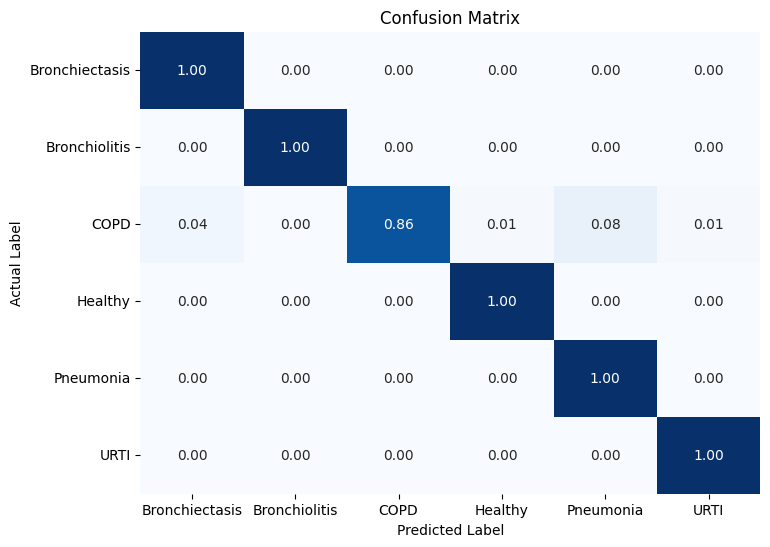

In [120]:
# Confusion Matrix
predictions = model.predict(X_test_reshaped)

predicted_classes = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), predicted_classes)
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [121]:
# Classification Report
print(classification_report(np.argmax(y_test, axis=1), predicted_classes))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        27
           1       1.00      1.00      1.00        18
           2       1.00      0.86      0.93        79
           3       0.97      1.00      0.98        29
           4       0.84      1.00      0.91        31
           5       0.94      1.00      0.97        16

    accuracy                           0.94       200
   macro avg       0.94      0.98      0.96       200
weighted avg       0.95      0.94      0.94       200

